# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [2]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from progressbar import progressbar
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from playsound import playsound

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [3]:
def loss_function(x, y):
    return np.mean((x - y) ** 2)

def loss_derivative(x, y):
    return 2 * (x - y)

def reshaping(X_set):
    new_X_set = np.empty((X_set.shape[0], X_set.shape[1], 1))
    for i in range(len(X_set)):
        temp = X_set[i]
        temp = temp.reshape((X_set.shape[1], 1))
        new_X_set[i] = temp
    return new_X_set

def regression_plot(predicted_values, real_values):
    plt.figure(figsize=(7, 6))
    plt.scatter(real_values, predicted_values, color='blue', label='Predicted vs. Real')

    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title('Regression Plot: Predicted vs. Real Values')

    # Idealna predykcja
    max_val = max(max(real_values), max(predicted_values))
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Perfect Prediction')

    plt.legend()
    plt.grid(True)
    plt.show()


In [5]:
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate

class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int, act_func:Layer, momentum:float=0.2) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros((output_size, 1))
        self.input = None
        self.output = None
        self.act_func = act_func
        self.momentum = momentum
        self.prev_weights_update = np.zeros_like(self.weights)
        self.prev_biases_update = np.zeros_like(self.biases)


    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.dot(self.weights, x) + self.biases
        return self.act_func.forward(self.output)

    def backward(self, output_error_derivative) -> np.ndarray:
        new_output_error_derivative = self.act_func.backward(output_error_derivative)
        input_error_derivative = np.dot(self.weights.T, new_output_error_derivative)
        weights_error_derivative = np.dot(new_output_error_derivative, self.input.T)
        weights_update = self.learning_rate * weights_error_derivative + self.momentum * self.prev_weights_update
        biases_update = self.learning_rate * np.sum(new_output_error_derivative, axis=1, keepdims=True) + self.momentum * self.prev_biases_update

        self.weights -= weights_update
        self.biases -= biases_update
        self.prev_weights_update = weights_update
        self.prev_biases_update = biases_update

        return input_error_derivative



class Tanh(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.input = None
        self.output = None

    def forward(self, x:np.ndarray)->np.ndarray:
        self.input = x
        self.output = np.tanh(x)
        return self.output

    def backward(self, output_error_derivative)->np.ndarray:
        return output_error_derivative * (1 - np.tanh(self.input) ** 2)
    
class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, output_error_derivative) -> np.ndarray:
        return output_error_derivative * self.output * (1 - self.output)
    
class ReLU(Layer):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        self.output = np.maximum(0, x)
        return self.output

    def backward(self, output_error_derivative) -> np.ndarray:
        return output_error_derivative * (self.input > 0).astype(int)


class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function for a particular x"""
        return self.loss_function(x, y)

    def loss_derivative(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)

class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            learning_rate:float,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        all_current_loss = []
        epoch_loss = np.zeros(1437)
        for layer in self.layers:
            layer.learning_rate = self.learning_rate
        for epoch in range(epochs):
            for i in range(len(x_train)):
                
                output = self(x_train[i])
                
                correct_result = np.zeros((10, 1))
                temp = y_train[i]
                correct_result[y_train[i]] = 1

                current_loss = self.loss.loss(output, correct_result)
                loss_derivative = self.loss.loss_derivative(output, correct_result)
                epoch_loss[i] = current_loss
                
                for layer in reversed(self.layers):
                    loss_derivative = layer.backward(loss_derivative)

            all_current_loss.append(np.mean(epoch_loss))
            if verbose:
                print(np.mean(epoch_loss))
        fig2 = plt.plot(all_current_loss)
        plt.show()

In [6]:
def sigmoid_tester(learning_rate, epochs, random_state, amount_of_layers, verbose):
    # sigmoid lr=0.05 e=200
    digits = load_digits()
    X = digits.data
    y = digits.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    new_X_train = reshaping(X_train)
    new_X_test = reshaping(X_test)

    if amount_of_layers == 3:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=Sigmoid()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=64, act_func=Sigmoid()),  # Ukryta warstwa
            FullyConnected(input_size=64, output_size=10, act_func=Sigmoid()),  # Warstwa wyjściowa
        ]
    elif amount_of_layers == 2:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=Sigmoid()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=10, act_func=Sigmoid()),  # Warstwa wyjściowa
        ]
    else:
        print('Wrong amount of layers')
        raise ValueError
    
    network = Network(layers=layers, learning_rate=learning_rate)

    loss = Loss(loss_function, loss_derivative)
    network.compile(loss=loss)

    network.fit(new_X_train, y_train, epochs, learning_rate, verbose)

    predictions_t = []
    for i in range(len(X_train)):
        output = network(new_X_train[i])
        prediction = np.argmax(output)
        predictions_t.append(prediction)

    accuracy = np.mean(np.array(predictions_t) == y_train)
    print(f"Accuracy on train set: {accuracy}")
    regression_plot(predictions_t, y_train)
    predictions = []
    for i in range(len(X_test)):
        output = network(new_X_test[i])
        prediction = np.argmax(output)
        predictions.append(prediction)

    accuracy = np.mean(np.array(predictions) == y_test)
    print(f"Accuracy on test set: {accuracy}")

    
    regression_plot(predictions, y_test)

def tanh_tester(learning_rate, epochs, random_state, amount_of_layers, verbose):
    digits = load_digits()
    X = digits.data
    y = digits.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    new_X_train = reshaping(X_train)
    new_X_test = reshaping(X_test)

    if amount_of_layers == 3:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=64, act_func=Tanh()),  # Warstwa wejściowa
            FullyConnected(input_size=64, output_size=32, act_func=Tanh()),  # Ukryta warstwa
            FullyConnected(input_size=32, output_size=10, act_func=Tanh()),  # Warstwa wyjściowa
        ]
    elif amount_of_layers == 2:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=Tanh()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=10, act_func=Tanh()),  # Warstwa wyjściowa
        ]
    else:
        print('Wrong amount of layers')
        raise ValueError
    
    network = Network(layers=layers, learning_rate=learning_rate)

    loss = Loss(loss_function, loss_derivative)
    network.compile(loss=loss)

    network.fit(new_X_train, y_train, epochs, learning_rate, verbose=verbose)

    predictions_t = []
    for i in range(len(X_train)):
        output = network(new_X_train[i])
        prediction = np.argmax(output)
        predictions_t.append(prediction)

    accuracy = np.mean(np.array(predictions_t) == y_train)
    print(f"Accuracy on train set: {accuracy}")

    predictions = []
    for i in range(len(X_test)):
        output = network(new_X_test[i])
        prediction = np.argmax(output)
        predictions.append(prediction)

    accuracy = np.mean(np.array(predictions) == y_test)
    print(f"Accuracy on test set: {accuracy}")
    regression_plot(predictions_t, y_train)
    regression_plot(predictions, y_test)

def ReLU_tester(learning_rate, epochs, random_state, amount_of_layers, verbose):
    digits = load_digits()
    X = digits.data
    y = digits.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    new_X_train = reshaping(X_train)
    new_X_test = reshaping(X_test)

    if amount_of_layers == 3:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=256, act_func=ReLU()),
            FullyConnected(input_size=256, output_size=128, act_func=ReLU()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=64, act_func=ReLU()),  # Ukryta warstwa
            FullyConnected(input_size=64, output_size=10, act_func=ReLU()),  # Warstwa wyjściowa
        ]
    elif amount_of_layers == 2:
        layers = [
            FullyConnected(input_size=X_train.shape[1], output_size=128, act_func=ReLU()),  # Warstwa wejściowa
            FullyConnected(input_size=128, output_size=10, act_func=ReLU()),  # Warstwa wyjściowa
        ]
    else:
        print('Wrong amount of layers')
        raise ValueError
    
    network = Network(layers=layers, learning_rate=learning_rate)

    loss = Loss(loss_function, loss_derivative)
    network.compile(loss=loss)

    network.fit(new_X_train, y_train, epochs, learning_rate, verbose=verbose)

    predictions = []
    for i in range(len(X_test)):
        output = network(new_X_test[i])
        prediction = np.argmax(output)
        predictions.append(prediction)

    accuracy = np.mean(np.array(predictions) == y_test)
    print(f"Accuracy on test set: {accuracy}")

    regression_plot(predictions, y_test)

Różne ziarna


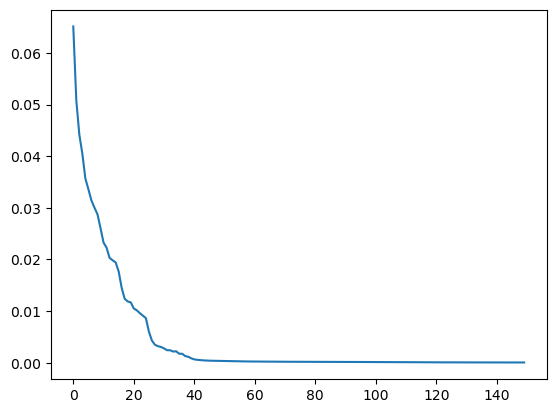

Accuracy on train set: 1.0


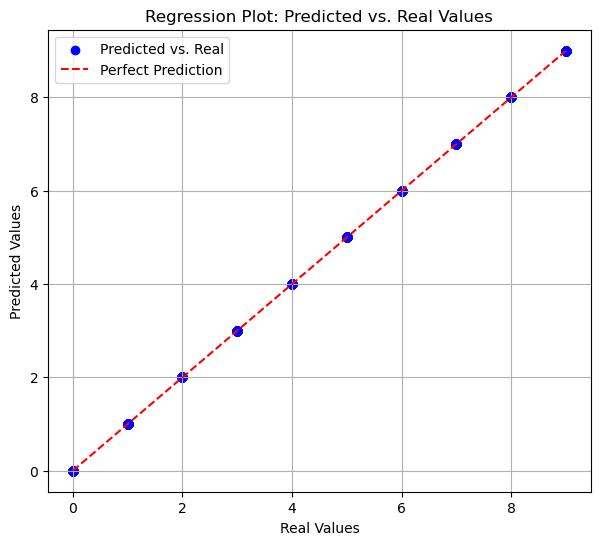

Accuracy on test set: 0.9485396383866481


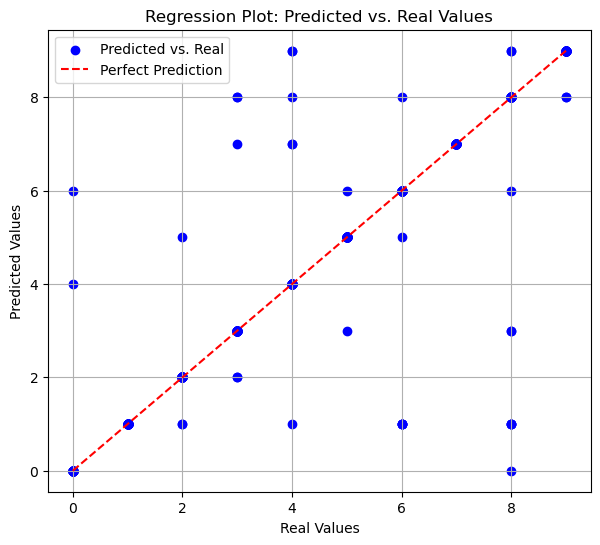

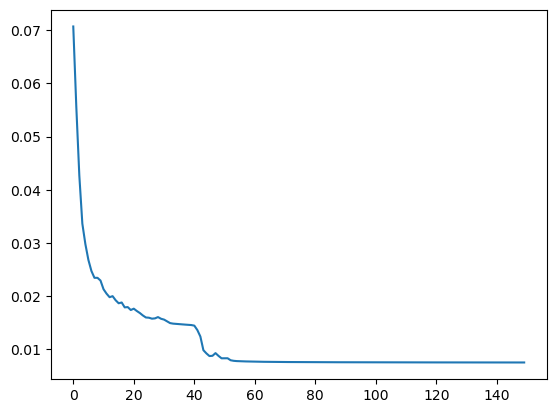

Accuracy on train set: 0.8998144712430427


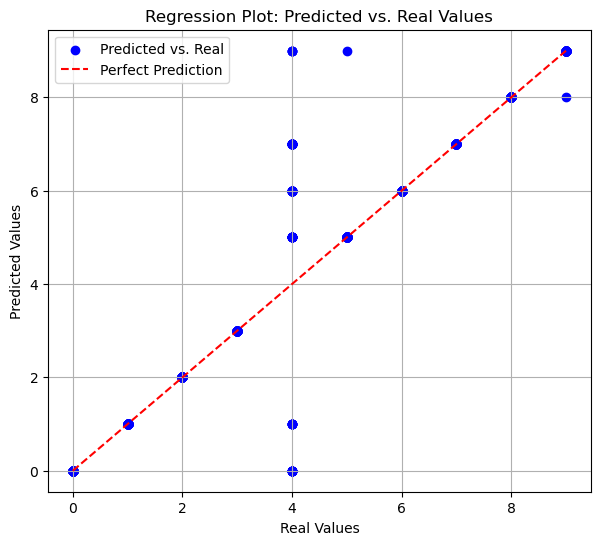

Accuracy on test set: 0.8539638386648123


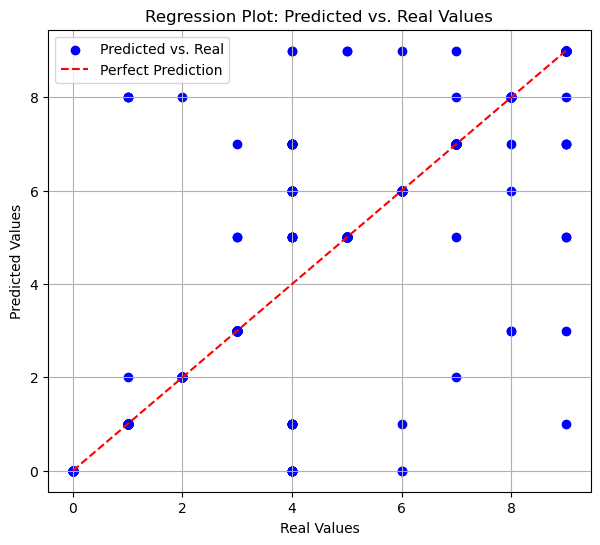

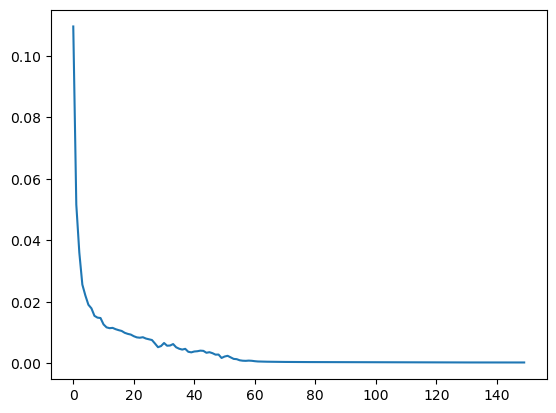

Accuracy on train set: 0.9972170686456401


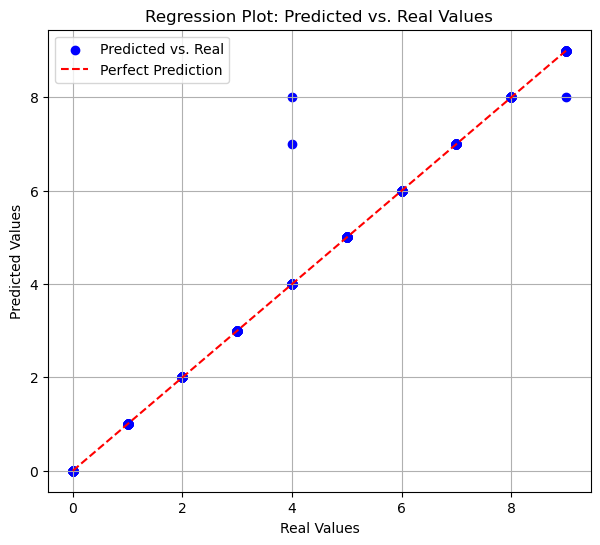

Accuracy on test set: 0.9457579972183588


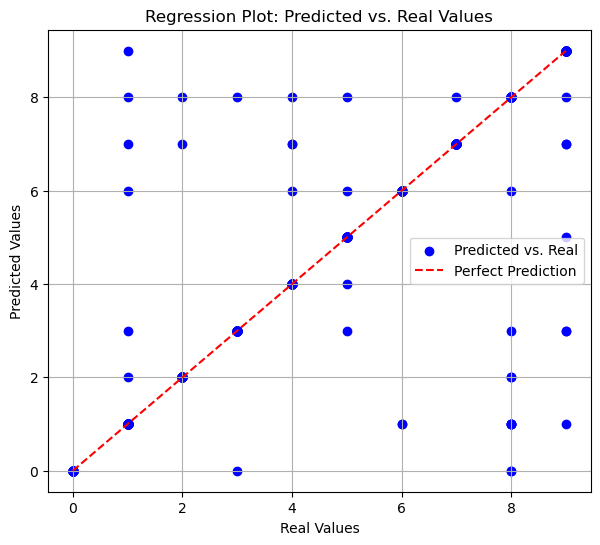

Duży learning rate


/tmp/ipykernel_416/1731722706.py:83: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


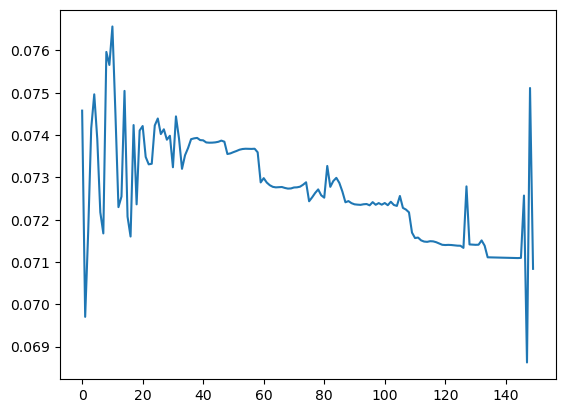

Accuracy on train set: 0.11224489795918367


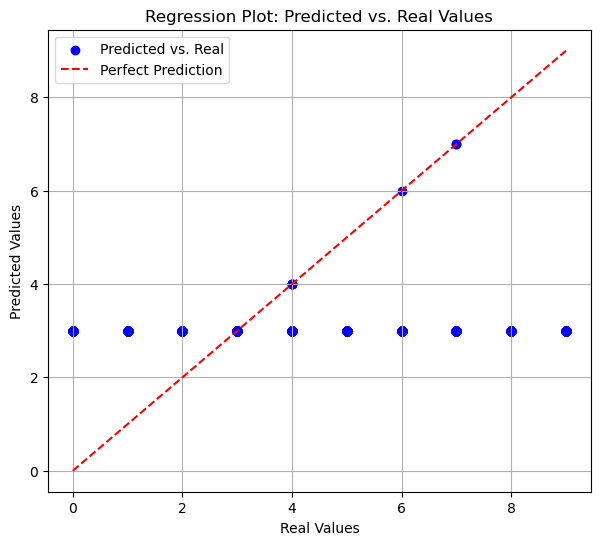

Accuracy on test set: 0.09874826147426982


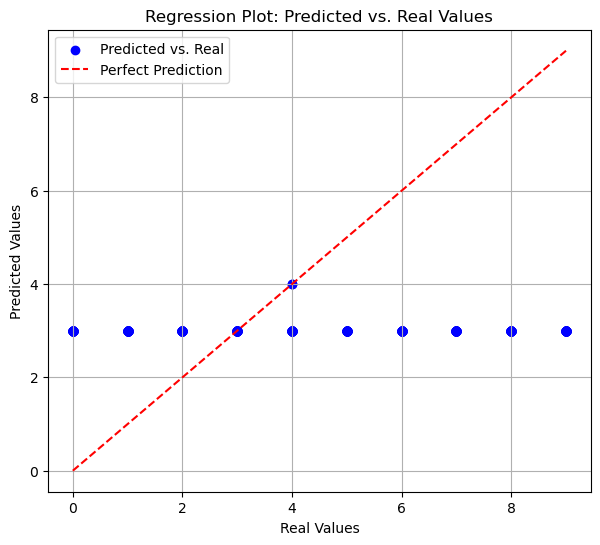

Mały learning rate


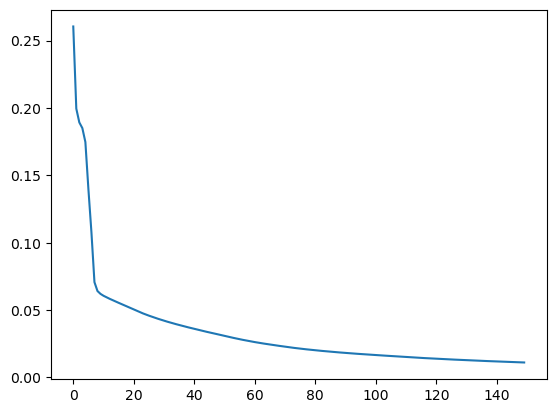

Accuracy on train set: 0.9341372912801484


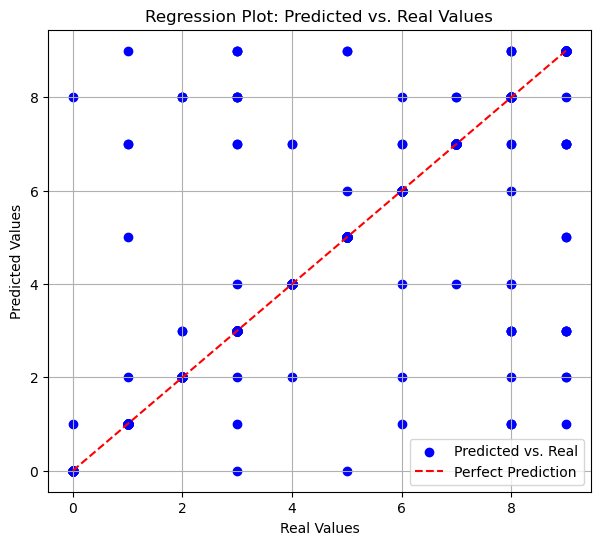

Accuracy on test set: 0.8150208623087621


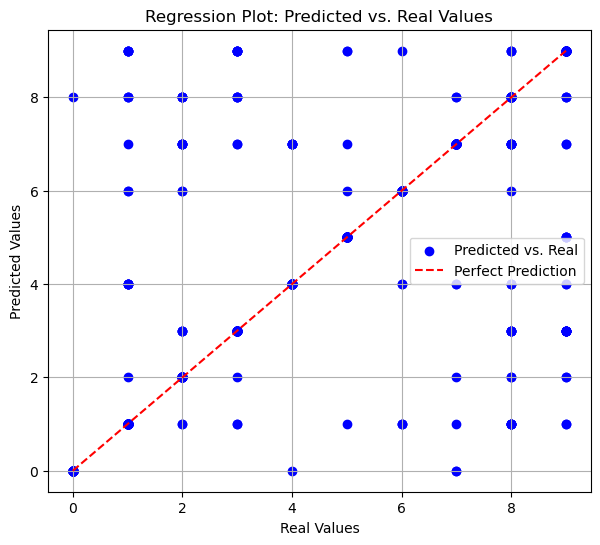

Mało epok uczenia


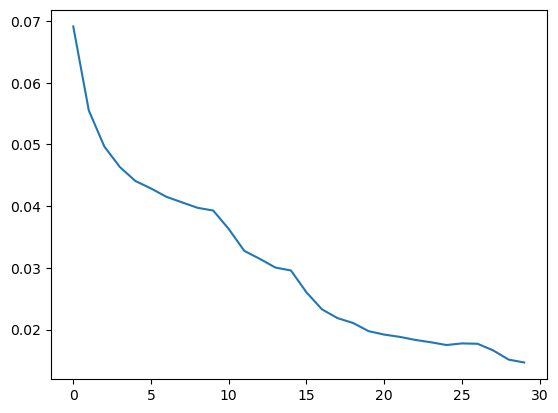

Accuracy on train set: 0.8562152133580705


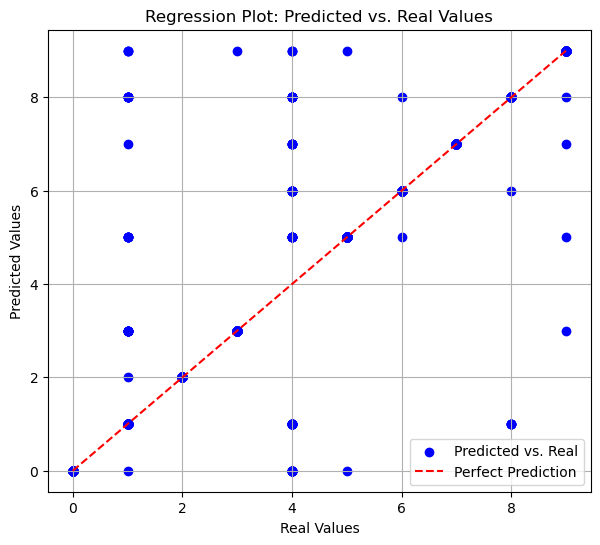

Accuracy on test set: 0.8108484005563282


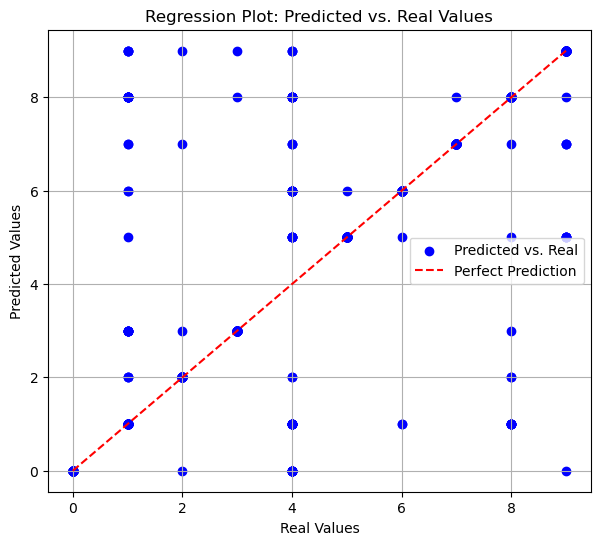

Dużo epok uczenia


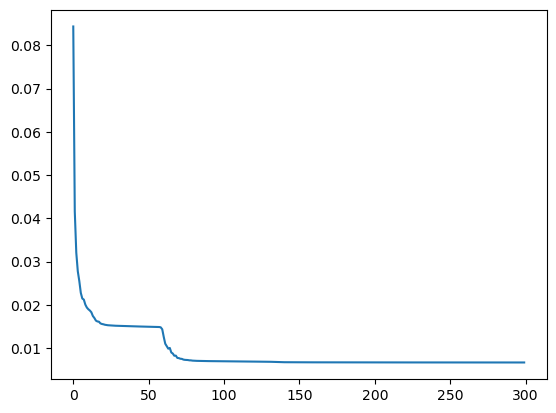

Accuracy on train set: 0.9109461966604824


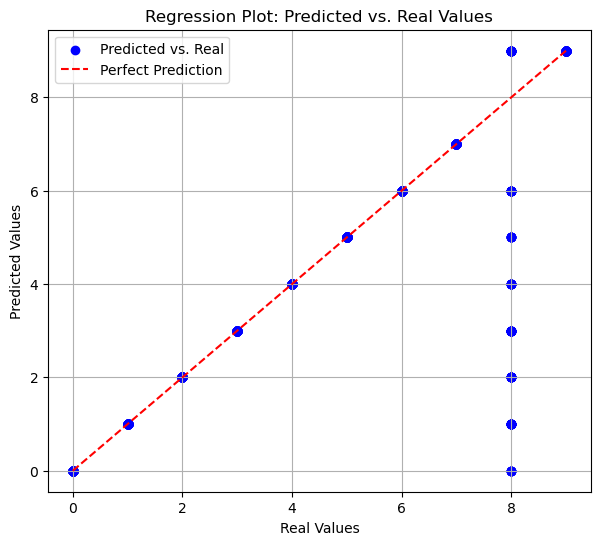

Accuracy on test set: 0.8609179415855355


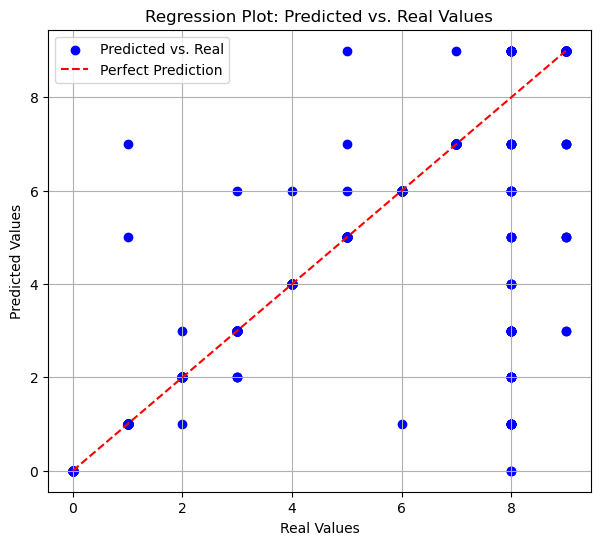

Dwie warstwy


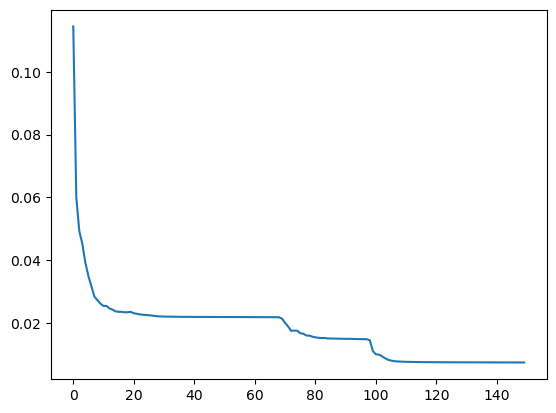

Accuracy on train set: 0.9035250463821892


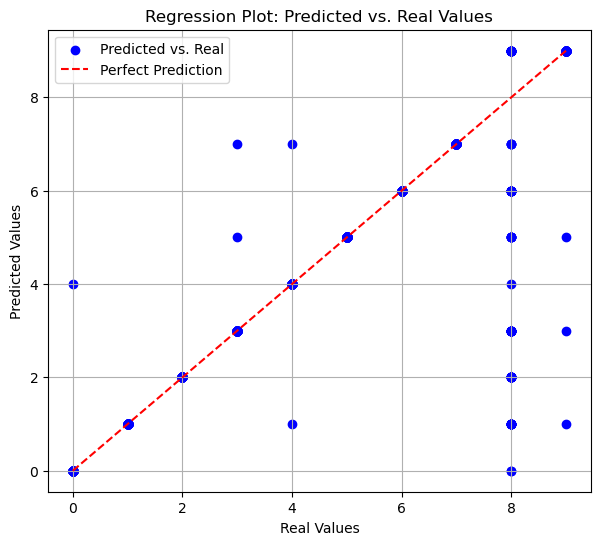

Accuracy on test set: 0.8539638386648123


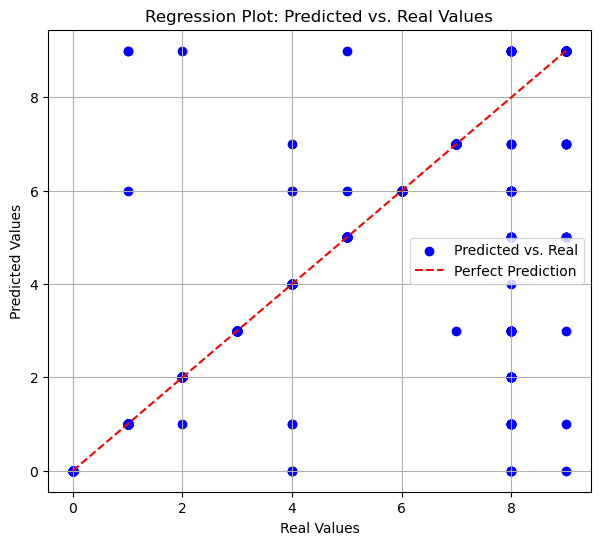

In [15]:
# momentum 0.5
print('Różne ziarna')
sigmoid_tester(0.05, 150, 60, 3, 0)
sigmoid_tester(0.05, 150, 20, 3, 0)
sigmoid_tester(0.05, 150, 40, 3, 0)

print('Duży learning rate')
sigmoid_tester(0.5, 150, 40, 3, 0)
print('Mały learning rate')
sigmoid_tester(0.001, 150, 40, 3, 0)
print('Mało epok uczenia')
sigmoid_tester(0.05, 30, 40, 3, 0)
print('Dużo epok uczenia')
sigmoid_tester(0.05, 300, 40, 3, 0)
print('Dwie warstwy')
sigmoid_tester(0.05, 150, 40, 2, 0)

0.7700545409201417
0.7565716860520459
0.7472770316836166
0.7455725925704715
0.7348842935645185
0.7307025058660649
0.7211435231623474
0.7135015622045925
0.7025201872141683
0.6981455004028798
0.6965820761562375
0.689583597952212
0.6892146352405699
0.6814270469018149
0.6821437040523693
0.6783076832335129
0.6754025396501228
0.6680299695831445
0.6636686976698583
0.6632362892697973
0.6579374526625319
0.6564403933458318
0.6545939251750791
0.6545430147046426
0.6511241813303695
0.6489140996075664
0.6450283167107025
0.6428073120606974
0.6438608132226294
0.6375736310011206
0.640509445254108
0.6375840165281073
0.6375733901555424
0.6314209156960627
0.6320182927175121
0.6311318352891867
0.6269211908297581
0.624532895790666
0.6218846392381255
0.6200393066660722
0.6207032708110609
0.617314927127098
0.618625825487881
0.6145282723903286
0.6157558764435075
0.6134644196946196
0.6125193446682703
0.6096601959723398
0.6094671049522641
0.6055223314696889
0.6047490444082462
0.604033246100622
0.6015844289245704

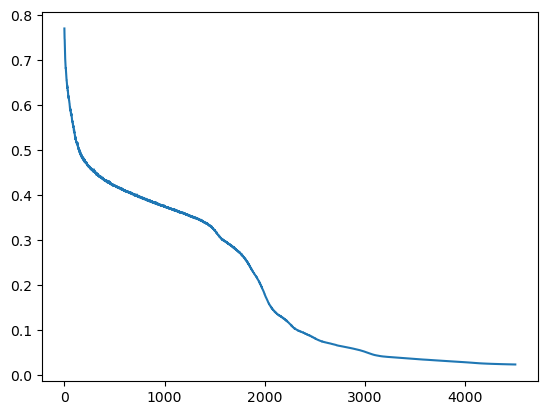

Accuracy on train set: 0.9341372912801484
Accuracy on test set: 0.7371349095966621


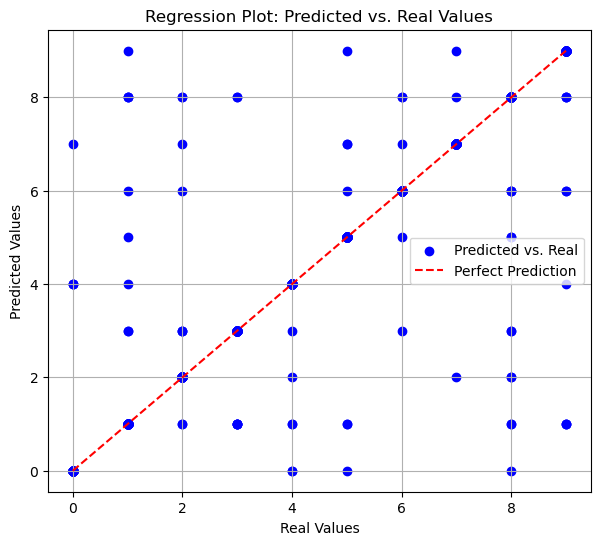

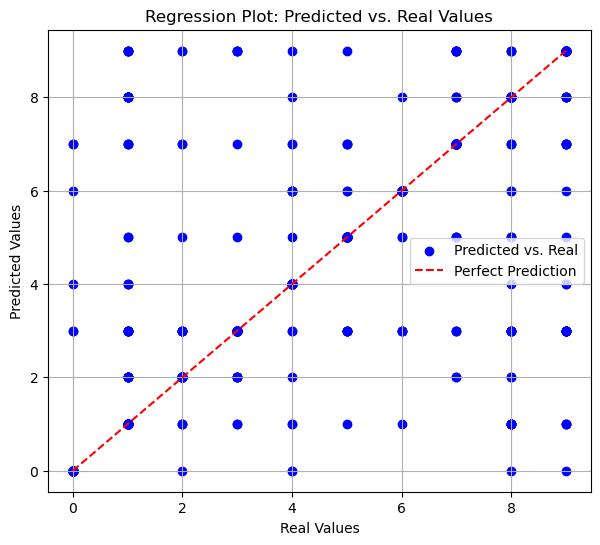

In [155]:
# lr=0.001 epoch=30 momentum=0.5
# lr=0.00001 epoch=300 momentum=0.9
# lr=0.0001 epoch=4500 momentum=0.2
tanh_tester(0.0001, 4500, 40, 3, 1)


0.7710968218705578
0.7275712689083726
0.6911901377536129
0.6672875558769801
0.6423184285403316
0.6325437102864412
0.6271282811242742
0.6275743693895478
0.6186723259177974
0.6159331388567036
0.614415727889252
0.6156265961955141
0.614298935238634
0.6047027664304411
0.5999499052503128
0.604341187271207
0.6035959839672297
0.6002971411551349
0.5935467150607504
0.5932699657188614
0.594320556361662
0.5875351579941505
0.5881439044321217
0.5807386106715292
0.5804712858673822
0.5779752016180603
0.5778792395896437
0.5716714774368047
0.5663903207326453
0.5638583121970121
0.5627798265030522
0.5518187298555665
0.5494727790638887
0.5453585320169071
0.539599289618933
0.5345575515918197
0.526312313390036
0.5251931015762459
0.5195086694064268
0.5181540664432626
0.5080658259650351
0.49640179542231183
0.498835515779177
0.4818619458672121
0.4746424625133542
0.4717828014048599
0.4579663000150638
0.4484582021189564
0.4425327146148785
0.4306639646290061
0.4309099997561306
0.41746075261949805
0.408779850076408

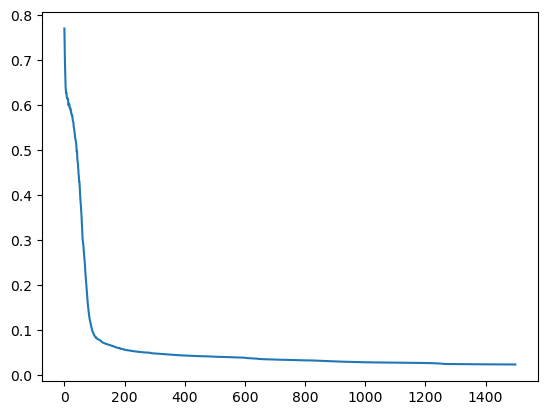

Accuracy on train set: 0.9090909090909091
Accuracy on test set: 0.808066759388039


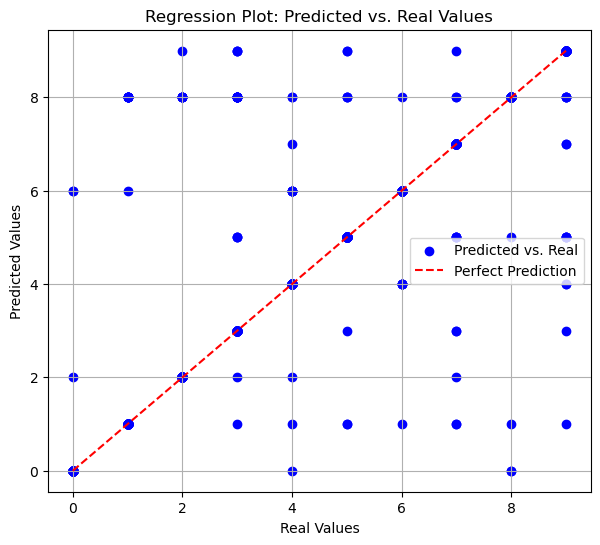

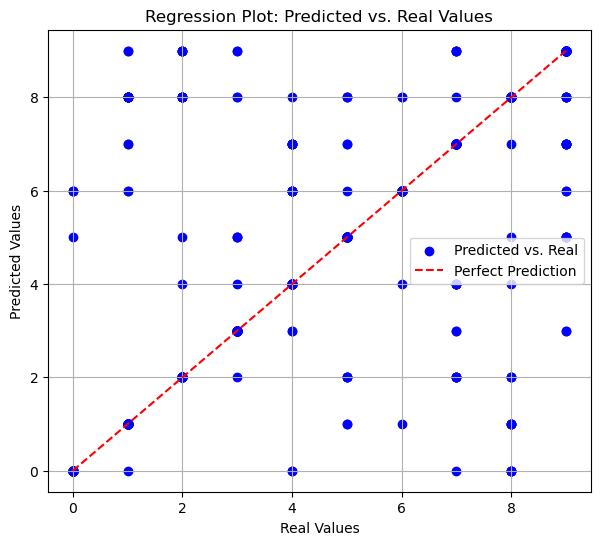

In [11]:
tanh_tester(0.001, 1500, 40, 2, 1)

# Wnioski

In [ ]:
Learning rate wpływa na tempo uczenia sieci. Zbyt duży może doprowadzić do niewystarczającego poziomu nauczenia sieci, 
z kolei zbyt mały spowalnia proces uczenia. 
Liczba epok określa długość uczenia. Za mała ilość skutkuje niedouczeniem sieci,a za duża ilość powoduje przeuczenie 
(zbytnie dopasowanie do zbioru uczącego).
Sieci z większą ilością warstw są w stanie odwzorować bardziej skomplikowane procesy, jednak ich proces uczenia jest dłuższy.
Ilość neuronów sieci wpływa na ilość informacji jaką model może przechowywać, jednak wartość nie może być zbyt duża, 
bo może doprowadzić do nadmiernego dopasowania.
Wszystkie te wartości wraz z funkcją aktywacji należy dopasować do konkretnego problemu, bez testów ciężko jest oszacować 
wartości hiperparametrów do dobrze działającego modelu.  